# opis problemu

## Wstęp fabularny

Zadaniem jest przygotować model uczenia maszynowego, który określać będzie nastawienie emocjonalne postów z Twittera. Zespół odpowiadający za zbieranie danych właśnie dostarczył zestaw danych.

Do tej pory klasyfikowaniem nastrojów z twittów zajmował się zespół ekspertów. Rozwiązanie takie jest bardzo wolne i drogie, a dokładność ekspertów wynosi tylko 95%. Dlatego zarząd firmy zlecił wdrożenie modelu uczenia maszynowego.

Model ma stanowić jedynie część większego produktu oferowanego przez firmę. Wyniki modelu będą bezpośrednio wykorzystywane przez następny zespół, którego zadaniem jest przygotować kolejny model uczenia maszynowego przewidujący reakcje opinii publicznej na posty klienta.

Prace zespołu, który korzystać będzie z modelu są już bardzo zaawansowane, dlatego nie może on pozwolić sobie na żadne dodatkowe zmiany w swoim projekcie. Absolutnie konieczne jest, aby model przyporządkowywał posty do jednej z trzech klas 'Positive', 'Negative', 'Neutral' lub analogicznych. Posty nie na temat powinny być klasyfikowane jako 'Neutral'.


## Polecenia

1. Wstępna obróbka danych:

 - załaduj zbiór treningowy i testowy,
 - usuń wiersze o brakujących elementach,
 - w kolumnie `sentiment` zamień wartości `'Irrelevant'` na `'Neutral'`.

1. Wykonaj wizualizacje danych:

 - histogram tematów twittów (`entity`),
 - histogram nastawień (`sentiment`),
 - najczęściej padających słów w treści twittów (`content`).

1. Przygotuj dane:

 - przygotuj zbiór cech poprzez wektoryzacje kolumny `content`, 
 - przygotuj etykiety poprzez zakodowanie tekstowych wartości w kolumnie `sentiment` do postaci liczbowej.

  Następnie wytrenuj naiwny model bayesowski. Sprawdź działanie modelu na kilku własnoręcznie napisanych wiadomościach. 

1. Wytrenuj modele:
 - naiwny bayesowski,
 - liniowy SVM,
 - regresji logistycznej,
 - drzewo decyzyjne.

  Sprawdź model na danych treningowych (walidacja krzyżowa) i testowych, następnie wybierz najlepszy model. Uzasadnij swój wybór.
  
1. Zespół ekspertów ręcznie klasyfikuje dane z dokładnością 95%. Porównaj z nimi swój model i napisz jakie są przewagi Twojego modelu.

## Zbiór danych

Zbiór danych został przygotowany na podstawie zbioru [Twitter Sentiment Analysis](https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis) i składa się z dwóch plików:
-  `twitter_training.csv` - zbiór treningowy,
- `twitter_validation.csv` - zbiór testowy.

Archiwum z plikami można pobrać z [dysku google](https://drive.google.com/file/d/1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB/view?usp=sharing) lub odkomentowując poniższe linie:

In [ ]:
! pip install gdown
! gdown https://drive.google.com/uc?id=1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB
! unzip twitter.zip

Downloading...
From: https://drive.google.com/uc?id=1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB
To: /content/twitter.zip
100% 2.07M/2.07M [00:00<00:00, 64.1MB/s]
Archive:  twitter.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace twitter_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# <center>Rozwiązanie</center>

## importy i funkcje

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(21,10)

import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from  sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

In [ ]:
!pip3 install nltk
import nltk
import ssl
# chcemy pobrac wytrenowany dla języka angielskeigo tokenizer Punkt
# poniższe linijki mają pomóc w przypadku problemów z ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# pobieramy tokenizer
nltk.download('punkt')
# ładujemy przydatne funkcje
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def ocena_jakosci(model,X_test,y_test):
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test,y_pred) # dokładność
    print('Accuracy: ',acc)
    print("Classification report:") # wypisz raport klasyfikacji 
    print(classification_report(y_test,y_pred))

    print("Macierz błędów") # wypisz macierz (confusion matrix)
    print(confusion_matrix(y_test,y_pred))

## wstępna obróbka danych

In [ ]:
df = pd.read_csv('twitter_training.csv')
df['content'].replace('  ', np.nan, inplace=True)
df=df.dropna()
df['sentiment'] = df['sentiment'].replace('Irrelevant', 'Neutral')
df.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_test = pd.read_csv('twitter_validation.csv')
df_test['content'].replace('  ', np.nan, inplace=True)
df_test=df_test.dropna()
df_test['sentiment'] = df_test['sentiment'].replace('Irrelevant', 'Neutral')
df_test.head()

,id,entity,sentiment,content
0,3364,Facebook,Neutral,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## wizualizacja danych

 * histogram tematów twittów (entity),
 * histogram nastawień (sentiment),


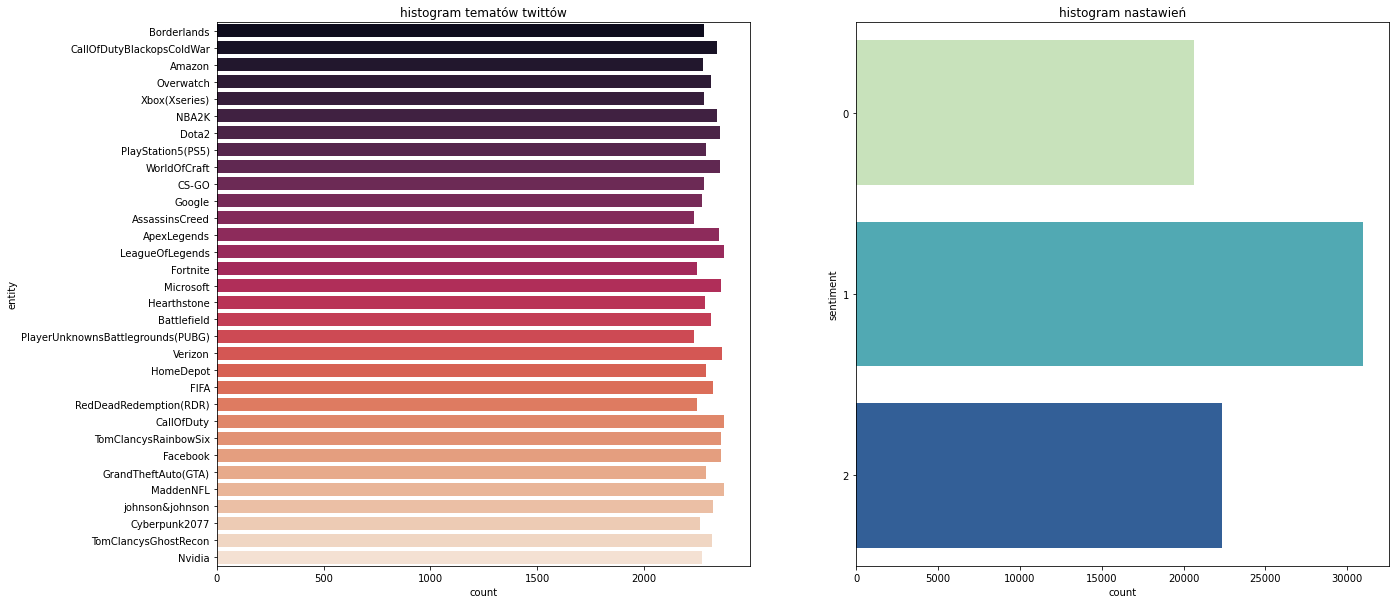

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('histogram tematów twittów')
sns.countplot(y='entity', data=df, ax=ax[0], palette='rocket')
ax[1].set_title('histogram nastawień')
sns.countplot(y='sentiment', data=df, palette='YlGnBu')
plt.show()

* najczęściej padających słów w treści twittów (content).

In [ ]:
positive_words = " ".join(list(df [df['sentiment']=='Positive']['content']))
positive_plot = WordCloud(width = 512, height = 512).generate(positive_words)

neutral_words = " ".join(list(df [df['sentiment']=='Neutral']['content'] ))
neutral_plot = WordCloud(width = 512, height = 512).generate(neutral_words)

negative_words = " ".join(list(df [df['sentiment']=='Negative']['content'] ))
negative_plot = WordCloud(width = 512, height = 512).generate(negative_words)

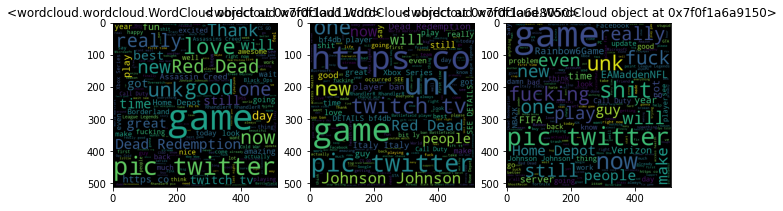

In [ ]:
ploty = [positive_plot, neutral_plot, negative_plot]
plt.figure(figsize=(10,8))

for index, plotek in enumerate(ploty):
    plt.subplot(1,3,index+1)
    plt.title(str(plotek))
    plt.imshow(plotek)

## dalsze przygotowanie danych

przygotowuję etykiety poprzez zakodowanie tekstowych wartości w kolumnie sentiment do postaci liczbowej

In [ ]:
df['sentiment'] = df['sentiment'].replace('Positive',0)
df['sentiment'] = df['sentiment'].replace('Neutral',1)
df['sentiment'] = df['sentiment'].replace('Negative',2)

df_test['sentiment'] = df_test['sentiment'].replace('Positive',0)
df_test['sentiment'] = df_test['sentiment'].replace('Neutral',1)
df_test['sentiment'] = df_test['sentiment'].replace('Negative',2)

świadomie pomijam w treningu kolumnę entity - na ten moment zakładam że content nie ma związku z przedmiotem wiadomości

In [ ]:
X_train = df.content
y_train = df.sentiment
y_train = y_train.astype('int')

X_test = df_test.content
y_test = df_test.sentiment
y_test = y_test.astype('int')

przygotowuję zbiór cech poprzez wektoryzacje kolumny content

In [ ]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)

In [ ]:
X_train= vectorizer.fit_transform(X_train)

In [ ]:
X_test = vectorizer.transform(X_test)

## <center> **TRENING MODELI** <center>

## bayes

In [ ]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [ ]:
ppv = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.51 +/- 0.05
REC = 0.51 +/- 0.05
ACC = 0.51 +/- 0.05
F1 = 0.51 +/- 0.05


In [ ]:
y_pred = ocena_jakosci(clf,X_test,y_test)

Accuracy:  0.813
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       277
           1       0.91      0.75      0.82       457
           2       0.73      0.87      0.79       266

    accuracy                           0.81      1000
   macro avg       0.81      0.83      0.81      1000
weighted avg       0.83      0.81      0.81      1000

Macierz błędów
[[239  18  20]
 [ 48 342  67]
 [ 19  15 232]]


Sprawdźmy, czego właściwie maszyna się nauczyła:

In [ ]:
feature_names = vectorizer.get_feature_names()
feature_names = np.array(feature_names)

coef=clf.coef_[0]
top10 = np.argsort(coef)[-10:]
bottom10 = np.argsort(coef)[:10]

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość jest negatywna:")
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość jest negatywna:
['game' 'in' 'thi' 'for' 'is' 'of' 'it' 'and' 'to' 'the']
Słowa najmniej istotne przy klasyfikacji:
['foxconn' 'h0x8j' 'sundarban' 'h1t' 'h1tv' 'h264' 'sundar' 'h2k'
 'h2qsg5djdv' 'h3tygk09']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Sprawdzenie działania na przykładowej, pozytywnej wiadomości

In [ ]:
our_message = 'lets play'
vectorized_message = vectorizer.transform([our_message])
result = clf.predict(vectorized_message)

if result[0] == 0:
    res = 'positive'
if result[0] == 1:
    res = 'neutral'
if result[0] == 2:
    res = 'negative'

print('The sentence \''+our_message + '\' is ' + res)

The sentence 'lets play' is positive


## regresja logistyczna

In [ ]:
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=3000)

In [ ]:
ppv = cross_val_score(lr, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(lr, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.50 +/- 0.04
REC = 0.50 +/- 0.04
ACC = 0.50 +/- 0.04
F1 = 0.50 +/- 0.04


In [ ]:
y_pred=ocena_jakosci(lr,X_test, y_test)

Accuracy:  0.932
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       277
           1       0.95      0.93      0.94       457
           2       0.93      0.94      0.93       266

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Macierz błędów
[[258  17   2]
 [ 16 425  16]
 [ 10   7 249]]


## drzewo decyzyjne

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(X_train, y_train)

In [ ]:
ppv = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.44 +/- 0.03
REC = 0.44 +/- 0.03
ACC = 0.44 +/- 0.03
F1 = 0.44 +/- 0.03


In [ ]:
y_pred = ocena_jakosci(clf,X_test,y_test)

Accuracy:  0.558
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.24      0.35       277
           1       0.52      0.89      0.66       457
           2       0.70      0.32      0.44       266

    accuracy                           0.56      1000
   macro avg       0.63      0.48      0.48      1000
weighted avg       0.61      0.56      0.51      1000

Macierz błędów
[[ 66 197  14]
 [ 27 408  22]
 [  6 176  84]]


## SVC


In [ ]:
SVC = LinearSVC(dual = False, max_iter = 4000)
SVC.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=4000)

In [ ]:
ppv = cross_val_score(SVC, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(SVC, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(SVC, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(SVC, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.48 +/- 0.05
REC = 0.48 +/- 0.05
ACC = 0.48 +/- 0.05
F1 = 0.48 +/- 0.05


In [ ]:
y_pred = ocena_jakosci(SVC,X_test,y_test)

Accuracy:  0.944
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       277
           1       0.96      0.95      0.95       457
           2       0.94      0.94      0.94       266

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Macierz błędów
[[261  13   3]
 [ 12 432  13]
 [  8   7 251]]


# Podsumowanie

Przede wszystkim w trakcie wykonywania poleceń pojawił się problem z walidacją krzyżową, która na tym samym modelu zwraca dużo gorsze miary niż metryki danych testowych. Spróbowałabym rozwiązać ten problem zaczynając od zmiany parametru cv w cross_cal_score. Możliwe, że przy innym podziale niż 5 krotnym, np. dla pomieszanego cv funkcja dałaby lepsze wyniki. 


Najlepszą dokładnością dla danych testowych wykazał się model SVC, działający z dokładnością 94%.  Korzystanie z tego modelu jest zdecydowanie bardziej korzystne niż korzystanie z zespołu ekspertów - dokładność jest odrobinę niższa, ale za to pracownicy są kosztowniejszym i wolniejszym rozwiązaniem


